# Landscape response to time-dependent soil diffusion
Ryan M. Strickland <br>
8 October 2020

## Introduction
The purpose of this Landlab model is to explore the effects of changing the rate of soil diffusion during landscape development. Currently, there are two working versions of the model. The first version changes the diffusion constant (k) uniformly across the model space from an initial value to a final value for a user-specified period of time (later referred to as the time-dependent diffusion component). The second version incorporates Celllab-CTS (later referred to as the cellular automaton or CA component) to stochastically apply a new diffusion constant for nodes at a user-specified rate.

Currently, the cellular automaton model is very basic and only incorporates two states: 0 or 1. The 0-state corresponds to the initial value for the diffusion constant (k_inital). The 1-state corresponds to the final value of the diffusion rate constant. A random selection of nodes in the model space are initially given the 1-state. The remaining nodes begin at the 0-state. If 0-state node borders a 1-state node, it has a probability of changing to the 1-state, as determined by the transition rate. Once a node changes to the 1-state, it never changes back. 

The cellular automaton portion of this model has questionable value. I am pleased that I successfully incorporated it into the model, but I do not think it appropriately models any natural phenomena. The timescales of geologic processes are likely one or two orders of magnitude greater than local changes in diffusion.

On the other hand, I believe the time-dependent diffusion component to more realistically model changes in diffusion across a landscape. The rate of diffusion uniformly changes in equal increments across the landscape, beginning at a certain time and changing for a pre-determined period of time. I will most likely use this component of the model for further exploration. 

In [1]:
from landlab.components import FlowAccumulator, FastscapeEroder, PerronNLDiffuse
from landlab.plot import imshow_grid
from landlab import RasterModelGrid #, load_params
from landlab.ca.celllab_cts import Transition, CAPlotter
from landlab.ca.raster_cts import RasterCTS
from matplotlib.pyplot import figure #, show, plot, xlabel, ylabel, title
import matplotlib
import numpy as np
#import matplotlib.pyplot as plt
#from landlab.io.netcdf import write_netcdf

Below is the transition function for the cellular automaton component. Feel free to change the rate (currently set at 0.5 transitions per second) to any value you wish. The larger the transition rate, the more rapidly all nodes will assume the final diffusion rate constant. The more nodes in the model space, the greater the diffusion rate constant should be. 

In [2]:
#Define the cellular automaton transition function
def transitions():
    xn_list = []
    
    #Transition((initial-state, initial-state, orientation), 
    #               (final-state, final-state, orientation), rate, 'name')
    #Note the rate is transitions per second. 
    xn_list.append(Transition((0, 1, 0), (1, 1, 0), .5, 'left-right transition'))
    xn_list.append(Transition((1, 0, 0), (1, 1, 0), .5, 'left-right transition'))
    #These transitions are the most basic and symmetrical.
    #Once a node is "seeded" with state "1", it will gradually change all the  
    #bordering nodes to state "1"
    
    return xn_list

All mandatory user input parameters are found in the cell below. This model is time-intensive for large grids. 

In [3]:
'''INPUT PARAMETERS'''
#Model geometry parameters
cell_dim = 5. #cell width/length in km
grid_width = 100 #number of nodes width
grid_height = 100 #number of nodes height

#Diffusion and stream power input parameters
uplift_rate = 0.001 #Units of m/yr
k_initial = 0.002 #Constant 0 < k < 0.01 generally, grid units are km
k_final = 0.02
t_trans = 1000 #Number of years for transition from k_initial to k_final
trans_start_t = 50000 #Year the k transition begins
k_streampower = 0.3
m_streampower = 0.5
total_t = 100000 #Total time 
dt =  100 #Timestep size
n_steps = total_t // dt #The number of steps in the model run

#Cellular automaton parameters
n_seed = 10 #Number of nodes initially assigned the 1-state
plot_interval = 10. #needed if plotting cellular automaton transitions
run_duration = 100. #The number of seconds the cellular automaton model should run per timestep dt
#report_interval = plot_interval #needed if plotting node state transitions

In [ ]:
#Create a csv file with the model parameters, if desired
#probably turn this into a dictionary later on
# parameter_names = ['cell_dim', 'grid_width', 'grid_height', 'uplift_rate', 
#                    'k_initial', 'k_final', 'k_streampower', 'm_streampower',
#                    'total_t', 'dt', 'n_steps', 'plot_interval', 'run_duration']
# parameter_values = [cell_dim, grid_width, grid_height, uplift_rate, 
#                    k_initial, k_final, k_streampower, m_streampower,
#                    total_t, dt, n_steps, plot_interval, run_duration]

# import pandas as pd
# fname = #csv filepath and name 
# df = pd.DataFrame([parameter_names, parameter_values], columns = ['Parameter', 'Value'])
# df.to_csv(fname, index = False)

The following cell instantiates all the model space with the user-specified initial conditions.

In [4]:
'''MODEL INSTANTIATION-DO NOT EDIT'''
#Instantiate Landlab RasterModelGrid
mg = RasterModelGrid((grid_width, grid_height), cell_dim) #Instantiate the model space

#Create the topographic__elevation array, fill with zeros
z = mg.add_zeros('node', 'topographic__elevation') #Base topographic elevation is zeros
initial_roughness = np.random.rand(z.size) / 100000.
z += initial_roughness

#Create the diffusivity array, fill with zeros
k = mg.zeros('node', dtype = float)
k += [k_initial for _ in range(mg.number_of_nodes)]
k_field = mg.add_field('node', 'diffusivity', k, noclobber = False)

#Create the node state array for the cellular automaton component
#Create the node-state dictionary
ns_dict = {0 : 'k_i', 1 : 'k_f'}

#Setup cellular automaton plot colors
#This is only needed if you intend to plot the cellular automaton grids.
k_i = 'skyblue'
k_f = 'red'
colorList = [k_i, k_f]
my_cmap = matplotlib.colors.ListedColormap(colorList)

xn_list = transitions() #Initiate the transitions
node_state_grid = mg.zeros('node', dtype = int)
node_state_field = mg.add_field('node', 'k_diff_transitions', node_state_grid)

#Create initial conditions for cellular automaton component
#This is not working as intended, but does the job
for x in range(n_seed):
    rand = np.random.randint(len(mg.core_nodes))
    node_state_grid[rand] = 1

#Needed for plotting cellular automaton transitions
#current_real_time = time.time()
#next_report = current_real_time + report_interval
            
#Establish boundary conditions
mg.set_fixed_value_boundaries_at_grid_edges(True, True, True, True)

Below I setup all the components.

In [5]:
'''SETUP THE COMPONENTS'''
#Setup the modules
nonlinear_diffuser = PerronNLDiffuse(mg, nonlinear_diffusivity = k)
flowRouter = FlowAccumulator(mg)
streamPower = FastscapeEroder(mg, K_sp = k_streampower, m_sp = m_streampower)
ca_diffusion_transition = RasterCTS(mg, ns_dict, xn_list, node_state_grid)

## Run the Model: Time-dependent diffusion 

This cell exectutes the time-dependent diffusion model. Please be aware you must re-instantiate the model and parameters between model runs. 

0 years have elapsed
5000 years have elapsed
10000 years have elapsed
15000 years have elapsed
20000 years have elapsed
25000 years have elapsed
30000 years have elapsed
35000 years have elapsed
40000 years have elapsed
45000 years have elapsed
50000 years have elapsed
55000 years have elapsed
60000 years have elapsed
65000 years have elapsed
70000 years have elapsed
75000 years have elapsed
80000 years have elapsed
85000 years have elapsed
90000 years have elapsed
95000 years have elapsed
100000 years have elapsed. Model complete.


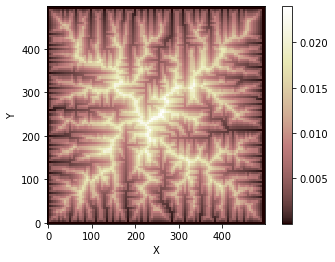

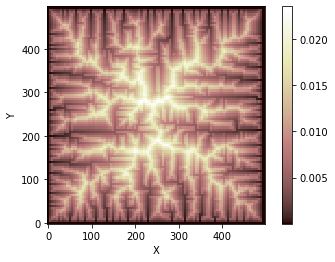

In [6]:
'''RUN THE MODEL---NO CELLULAR AUTOMATON COMPONENT'''
#Establish a steady state landscape under the initial conditions
for i in range(n_steps):
    z[mg.core_nodes] += uplift_rate * dt #add uplift
    nonlinear_diffuser.run_one_step(dt) #run diffusion one step
    flowRouter.run_one_step() #run the flow router
    streamPower.run_one_step(dt) #run stream power incision
    
    #This is the time-dependent diffusion component
    #It increases k from k_initial to k_final in time t_trans
    if i == (trans_start_t // dt):
        figure()
        imshow_grid(mg, 'topographic__elevation')
    
    if i >= (trans_start_t // dt) and i < ((trans_start_t + t_trans) // dt):
        k[mg.core_nodes] += (k_final - k_initial) / (t_trans / dt)
    
    if i % 50 == 0:
        print(i * dt, "years have elapsed")

print(total_t, "years have elapsed. Model complete.")

figure()
imshow_grid(mg, 'topographic__elevation')

## Run the Model: Cellular automaton component

This cell exectutes the cellular automaton model. Please be aware you must re-instantiate the model and parameters between model runs. 

In [ ]:
'''RUN THE MODEL---WITH CELLULAR AUTOMATON COMPONENT'''
#Establish a steady state landscape under the initial conditions
for i in range(n_steps // 2):
    z[mg.core_nodes] += uplift_rate * dt #add uplift
    nonlinear_diffuser.run_one_step(dt) #run diffusion one step
    flowRouter.run_one_step() #run the flow router
    streamPower.run_one_step(dt) #run stream power incision
    
    if i % 50 == 0:
        print(i * dt, "years have elapsed")

print(total_t, "years have elapsed.")
print("CA component now active.")

figure()
imshow_grid(mg, 'topographic__elevation')


#Initiate the cellular automaton model
for i in range(n_steps // 2):
    z[mg.core_nodes] += uplift_rate * dt #add uplift
    nonlinear_diffuser.run_one_step(dt) #run diffusion one step
    flowRouter.run_one_step() #run the flow router
    streamPower.run_one_step(dt) #run stream power incision
    
    current_time = 0. #run the cellular automaton for run_duration each timestep i
    while current_time < run_duration:
        ca_diffusion_transition.run(current_time + plot_interval, ca_diffusion_transition.node_state, plot_each_transition = False)
        current_time += plot_interval
    k[node_state_grid == 1] = k_final #Update the k field with the new value

    
    if i % 50 == 0:
        print(i * dt, "years have elapsed")

figure()
imshow_grid(mg, 'topographic__elevation')
#write_netcdf('run1_hi-lo-1.nc', mg, format = 'NETCDF3_64BIT', names = 'topographic__elevation')

## Moving Forward 

